# **Detección de Fraude en Transacciones de Tarjetas de Crédito**

## Definición del Problema

El fraude con tarjetas de crédito representa una amenaza significativa para la integridad de las transacciones financieras y la confianza de los consumidores en el comercio digital. A medida que la dependencia de las tarjetas de crédito para las compras diarias continúa creciendo, también lo hace la sofisticación de los estafadores que explotan las vulnerabilidades del sistema. Este proyecto tiene como objetivo aplicar técnicas de aprendizaje automático para la detección de fraudes en transacciones de tarjetas de crédito.  A lo largo del proyecto, se sigue un flujo de análisis y desarrollo orientado a la clasificación de transacciones como fraudulentas (clase 1) o no fraudulentas (clase 0).

### **Dataset**
- **Fuente**: Kaggle ...
- **Descripción**: El **Credit Card Fraud Dataset** es un conjunto de datos que comprende 100000 transacciones generadas para simular la actividad de las tarjetas de crédito en el mundo real. Cada entrada incluye las siguientes características:
    - **TransactionID**:  Un identificador único para cada transacción, que garantiza la trazabilidad.
    - **TransactionDate**: La fecha y hora en que se produjo la transacción, lo que permite el análisis temporal.
    - **Amount**: El valor monetario de la transacción, que puede ayudar a identificar transacciones inusualmente grandes que pueden indicar fraude.
    - **MerchantID**: Un identificador para el comerciante involucrado en la transacción, útil para evaluar patrones de fraude relacionados con el comerciante.
    - **TransactionType**: Indica si la transacción fue una compra o un reembolso, proporcionando contexto para la actividad.
    - **Location**: La ubicación geográfica de la transacción, lo que facilita el análisis de las tendencias de fraude por región.
    - **IsFraud**: Una variable objetivo binaria que indica si la transacción es fraudulenta (1) o legítima (0), esencial para los modelos de aprendizaje supervisado.

### Pasos del Proyecto

#### 1. **Carga y Limpieza de Datos**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [64]:
data = pd.read_csv("./data/credit_card_fraud_dataset.csv")
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [65]:
data.info()
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


TransactionID      100000
TransactionDate    100000
Amount              90621
MerchantID           1000
TransactionType         2
Location               10
IsFraud                 2
dtype: int64

In [66]:
#Verificar valores nulos
data.isnull().sum()
#El dataset no contiene valores nulos

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [67]:
#Verificar valores duplicados
data.duplicated().sum()
#El dataset no contiene valores duplicados

0

#### 2. **Preprocesamiento de los Datos**
Se realiza mediante la estandarización de formatos, el escalado de valores y la codificación de variables categóricas, creando un conjunto de datos coherente y bien organizado. El objetivo es refinar los datos brutos en un formato que sea significativo para el análisis y la formación. Mediante la limpieza y el preprocesamiento de datos, nos aseguramos de que el modelo se entrene con datos fiables y de alta calidad.

#### Conversión de fechas: 
Convertir **TransactionDate** a datetime y extraer información útil como hora, día, etc.

In [68]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')
data['Hour'] = data['TransactionDate'].dt.hour
data['DayOfWeek'] = data['TransactionDate'].dt.dayofweek

#### Codificación de variables categóricas
Variables como **TransactionType**, **Location**, **MerchantID** deben convertirse a números

In [69]:
data = pd.get_dummies(data, columns=['TransactionType', 'Location'], drop_first=True)

#### Por qué **MerchantID** debe tratarse como **categórica** aunque sea un número?

**Porque no tiene orden ni magnitud**

Un **MerchantID** 100 no es "más" ni "menos" que un 200. No hay relación matemática entre ellos. Es simplemente un **identificador arbitrario.**

**Tratarlo como numérico (dejándolo como está):**
- El modelo asume que hay relaciones entre los IDs.
- Puede generar reglas como “si el MerchantID > 500, entonces hay más fraude”, lo cual **no tiene sentido real.**
- Esto introduce **ruido e interpretaciones erróneas.**

##### **¿Cómo tratarlo correctamente?**
- Opción 1: Codificación categórica (One-hot encoding (get_dummies))
    - Si tienes pocos comerciantes distintos
- Opción 2: Agrupar o reducir cardinalidad ( Agrupar + One-hot ("Top-N + Otros"))
    - Si hay muchos comerciantes (lo más probable), puedes:
        - Tomar los más frecuentes (top 20 o top 50).
        - Reemplazar los demás por "otros".
- Opción 3 (avanzada): Target Encoding
    - Si quieres usar información de fraude directamente:

#### Normalización o estandarización
Sobre todo útil si usarás modelos sensibles a escala (SVM, KNN, regresión logística)

- Normalizar Amount.

In [70]:
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])

#### 3. **Análisis Exploratorio de Datos (EDA)**

In [71]:
#Estadísticas generales
data.describe()

,TransactionID,TransactionDate,Amount,MerchantID,IsFraud,Hour,DayOfWeek,Amount_scaled
count,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,1.000000e+05
mean,50000.500000,2024-04-21 13:06:09.973745920,2497.092666,501.676070,0.010000,11.50084,3.017040,-1.006484e-16
min,1.000000,2023-10-21 09:28:35.824439,1.050000,1.000000,0.000000,0.00000,0.000000,-1.730468e+00
25%,25000.750000,2024-01-20 23:18:20.586056704,1247.955000,252.000000,0.000000,6.00000,1.000000,-8.660081e-01
50%,50000.500000,2024-04-21 13:39:35.701438976,2496.500000,503.000000,0.000000,12.00000,3.000000,-4.108860e-04
75%,75000.250000,2024-07-21 22:28:05.702624512,3743.592500,753.000000,0.000000,17.00000,5.000000,8.641793e-01
max,100000.000000,2024-10-21 09:20:35.961088,4999.770000,1000.000000,1.000000,23.00000,6.000000,1.735068e+00
std,28867.657797,NaN,1442.415999,288.715868,0.099499,6.91768,1.999027,1.000005e+00


####  Distribución de la variable objetivo: 
##### Transacciones fraudulentas vs. legítimas  (**Balance de clases**)
- ¿Cuántas transacciones son legítimas vs fraudulentas?

**Técnicas para abordar el desequilibrio de clases**
- Submuestreo (Under-sampling:): La estrategia más simple es seleccionar al azar la clase mayoritaria para equilibrarla con la clase minoritaria. Pero la limitación es que los datos eliminados aleatoriamente de la clase mayoritaria pueden ser útiles para crear un modelo sólido.

- Sobremuestreo (Over-sampling): La forma más sencilla de sobremuestrear es duplicar datos en la clase minoritaria, pero no se agregará nueva información al modelo. Alternativamente, podemos sintetizar datos de los existentes, referidos como sobremuestreo de minorías sintéticas o SMOTE para abreviar. SMOTE, presentado inicialmente por Nitesh Chawla en 2002, funciona seleccionando datos cercanos o similares en el espacio de características y dibujando una línea entre los datos y creando nuevos datos en un punto de la línea. Es eficaz porque los datos nuevos están cerca de la clase minoritaria en el espacio de características. Si desea obtener más información sobre SMOTE, no dude en leer el artículo de Nitesh .

Para que el algoritmo sea ágil adaptándose a nuevos comportamientos, es recomendable realizar de manera inteligente este over-sampling. En este caso, el replicar en mayor medida las muestras más recientes de fraude provoca que el algoritmo sea capaz de tenerlas en cuenta en un corto plazo desde que se comienzan a realizar.

IsFraud
0    99000
1     1000
Name: count, dtype: int64


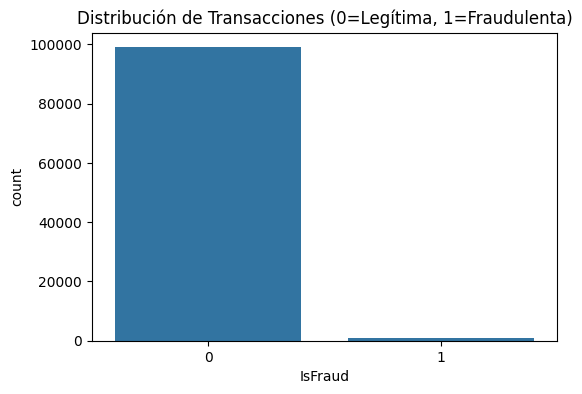

In [72]:
print(data['IsFraud'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='IsFraud', data=data)
plt.title('Distribución de Transacciones (0=Legítima, 1=Fraudulenta)')
plt.show()

#### Distribución del Monto en Transacciones Fraudulentas:
- ¿Hay diferencias significativas entre montos de transacciones fraudulentas y legítimas?
- ¿Existen valores atípicos (outliers) que puedan indicar posibles fraudes?


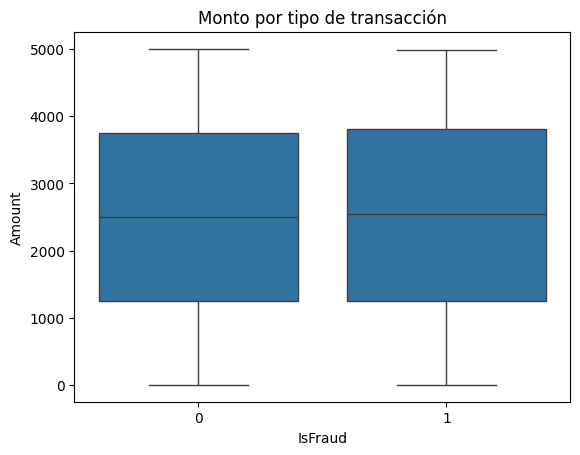

In [73]:
sns.boxplot(x='IsFraud', y='Amount', data=data)
plt.title('Monto por tipo de transacción')
plt.show()

In [74]:
# Calcula el importe medio de las transacciones fraudulentas
mediafraudulentas = data[data.IsFraud == 1]['Amount'].mean()

# Muestra el importe medio de las transacciones fraudulentas
print(f'Importe medio de las transacciones fraudulentas --> {mediafraudulentas:.2f}€')

Importe medio de las transacciones fraudulentas --> 2517.16€


Text(0.5, 0, 'Conteo')

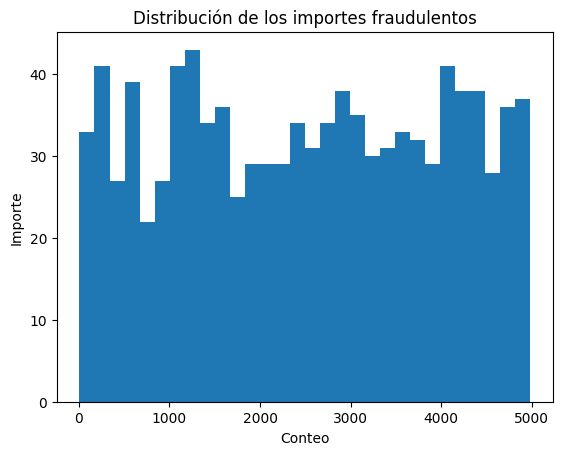

In [75]:
# Separa los datos de transacciones fraudulentas
data_fraudulentas = data[data.IsFraud == 1]['Amount']
data_fraudulentas.head()

# Muestra la distribución de los importes de las transacciones fraudulentas
fig, ax = plt.subplots()
ghistograma = ax.hist(data_fraudulentas, bins=30)
ax.set_title('Distribución de los importes fraudulentos')
ax.set_ylabel('Importe')
ax.set_xlabel('Conteo')

#### Distribución del tipo de transacción:
- ¿Hay algún tipo de transacción **(compra, reembolso)** más asociado al fraude?
- ¿Cuál es la distribución de tipos de transacción en general?

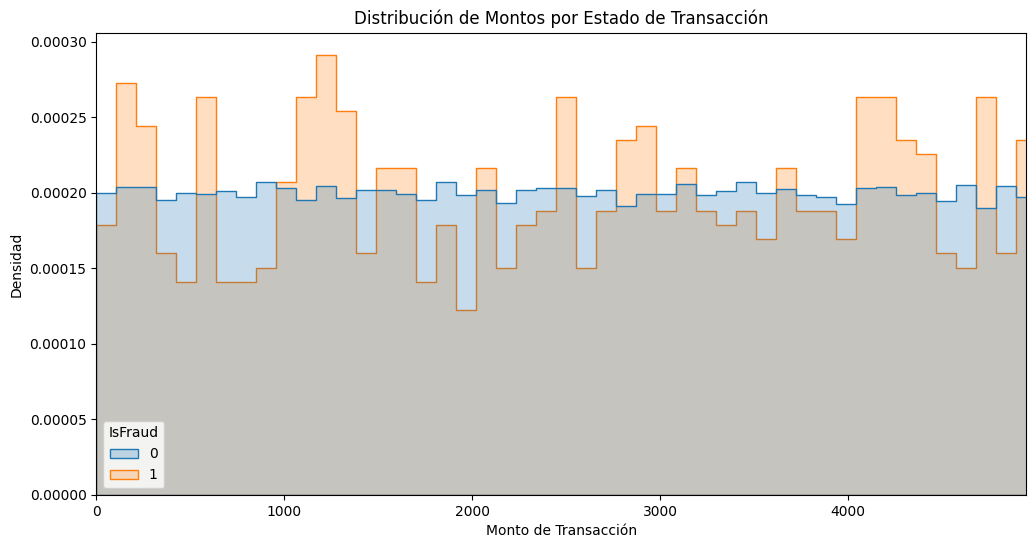

In [76]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Amount', hue='IsFraud', element='step', stat='density', common_norm=False)
plt.title('Distribución de Montos por Estado de Transacción')
plt.xlabel('Monto de Transacción')
plt.ylabel('Densidad')
plt.xlim(0, data['Amount'].quantile(0.99))  # Excluimos el 1% superior para mejor visualización
plt.show()

#### Análisis temporal (TransactionDate):
- ¿Hay patrones horarios, diarios o mensuales en las transacciones fraudulentas?
- ¿Ocurren más fraudes en ciertos días de la semana o en horarios nocturnos?      

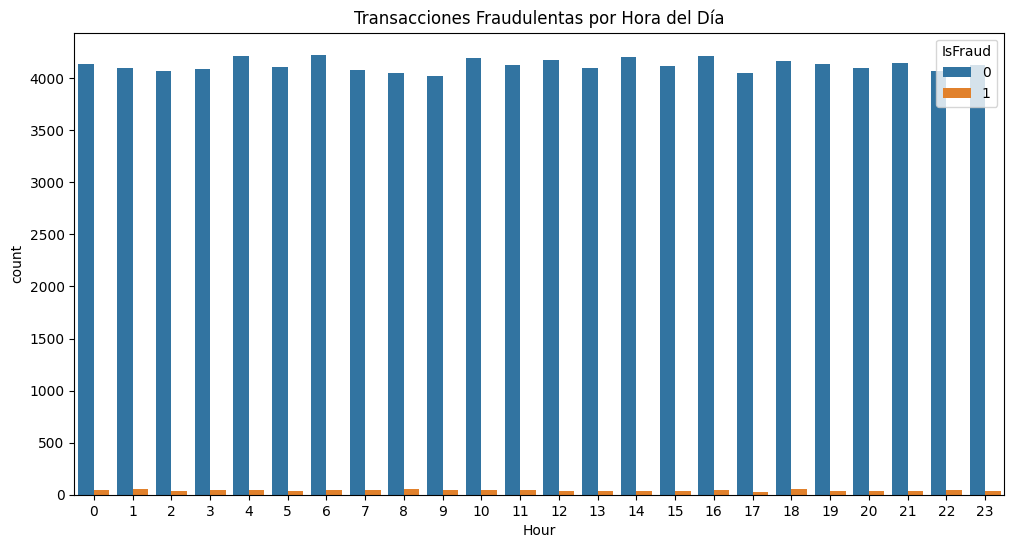

In [77]:
# Convertir a datetime y extraer características temporales
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Hour'] = data['TransactionDate'].dt.hour
data['DayOfWeek'] = data['TransactionDate'].dt.day_name()
data['Month'] = data['TransactionDate'].dt.month_name()

# Fraudes por hora del día
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', hue='IsFraud', data=data)
plt.title('Transacciones Fraudulentas por Hora del Día')
plt.show()

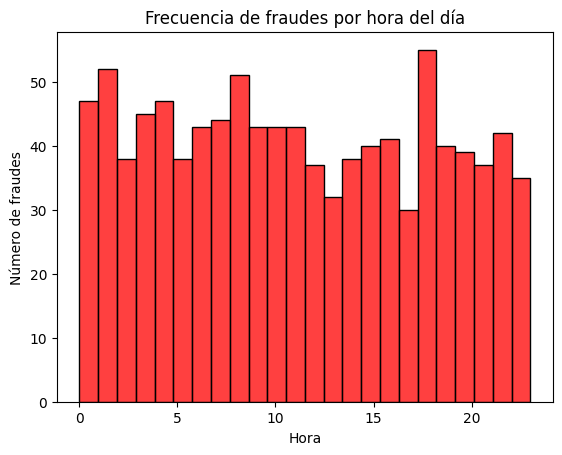

In [78]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')
data['Hour'] = data['TransactionDate'].dt.hour

sns.histplot(data[data['IsFraud'] == 1]['Hour'], bins=24, color='red')
plt.title('Frecuencia de fraudes por hora del día')
plt.xlabel('Hora')
plt.ylabel('Número de fraudes')
plt.show()


#### Análisis geográfico (Location):
- ¿Hay ciudades con mayor incidencia de fraudes?
- ¿Existen ubicaciones sospechosas con transacciones inusuales?

In [80]:
fraud_by_location = data[data['IsFraud'] == 1]['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
fraud_by_location.plot(kind='barh')
plt.title('Top 10 Ubicaciones con Más Transacciones Fraudulentas')
plt.xlabel('Cantidad de fraudes')
plt.ylabel('Ubicación')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

KeyError: 'Location'

In [ ]:
fraudes_por_comerciante = data[data['IsFraud'] == 1]['MerchantID'].value_counts()
print(fraudes_por_comerciante)

transacciones_por_comerciante = data['MerchantID'].value_counts()
#print(transacciones_por_comerciante)

MerchantID
640    5
958    5
156    5
583    5
744    4
      ..
396    1
105    1
613    1
366    1
108    1
Name: count, Length: 628, dtype: int64


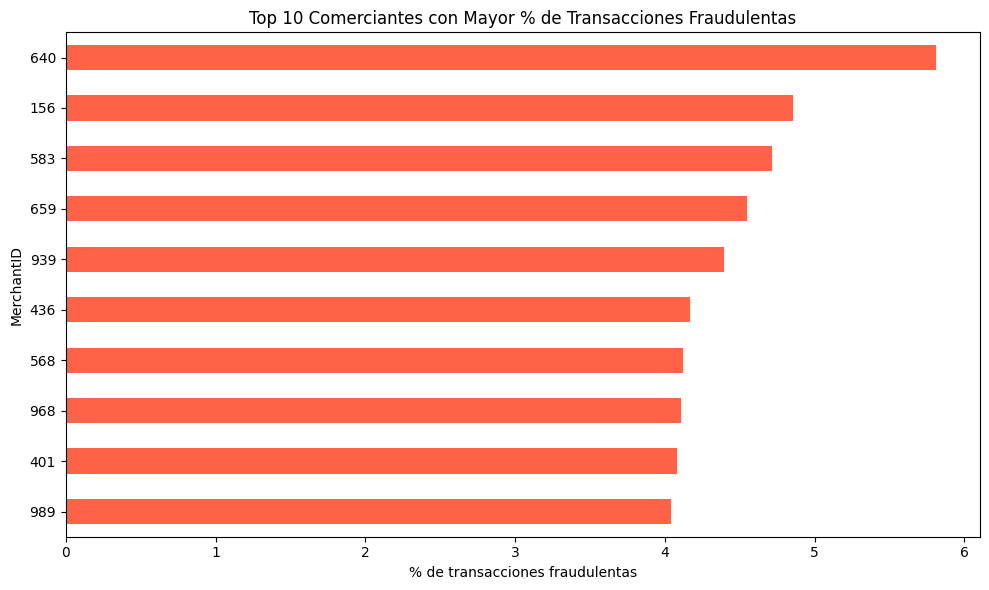

In [ ]:
fraudes_por_comerciante = data[data['IsFraud'] == 1]['MerchantID'].value_counts()

transacciones_por_comerciante = data['MerchantID'].value_counts()

porcentaje_fraude = (fraudes_por_comerciante / transacciones_por_comerciante) * 100

# Eliminar comerciantes con pocas transacciones (ej. < 30)
min_transacciones = 30
comerciantes_validos = transacciones_por_comerciante[transacciones_por_comerciante >= min_transacciones].index
porcentaje_fraude_filtrado = porcentaje_fraude[porcentaje_fraude.index.isin(comerciantes_validos)].dropna()

top_merchant_fraude = porcentaje_fraude_filtrado.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_merchant_fraude.plot(kind='barh', color='tomato')
plt.title('Top 10 Comerciantes con Mayor % de Transacciones Fraudulentas')
plt.xlabel('% de transacciones fraudulentas')
plt.ylabel('MerchantID')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 4. **Ingeniería y selección de características**
Proceso transformador que implica seleccionar solo características relevantes para la predicción del modelo. La selección de características refina el conjunto de variables, identificando las más relevantes para mejorar la eficiencia y la eficacia del modelo.

La ingeniería de características implica la selección de características relevantes o la creación de nuevas características mediante la transformación de las existentes para la predicción. Este proceso creativo requiere experiencia en el dominio y una comprensión profunda del problema, lo que garantiza que las características de ingeniería contribuyan significativamente a la predicción del modelo. Ayuda a la precisión al tiempo que minimiza la complejidad computacional.

#### 6. **Selección del modelo**
Para un buen modelo de aprendizaje automático, la selección del modelo es una parte muy importante, ya que necesitamos encontrar un modelo que se alinee con nuestro problema definido y las características del conjunto de datos. La selección del modelo es una decisión importante que determina el marco algorítmico para la predicción. La elección depende de la naturaleza de los datos, la complejidad del problema y los resultados deseados.

Estas son las características básicas de la selección de modelos:
- **Alineación:** seleccione un modelo que se alinee con el problema definido y las características del conjunto de datos.
- **Complejidad:** Tenga en cuenta la complejidad del problema y la naturaleza de los datos a la hora de elegir un modelo.
- **Factores de decisión:**  evalúe factores como el rendimiento, la interpretabilidad y la escalabilidad al seleccionar un modelo.
- **Experimentación:** Experimente con diferentes modelos para encontrar el que mejor se adapte al problema.